# Data Science Capstone - Final Project
### The Battle of the Neighbourhoods

#### Introduction

Urban food deserts are areas in large cities where it is difficult, time consuming, expensive, or unsafe for low income households to purchase healthy food. Food deserts typically have a low density of grocery stores or supermarkets, a high density of fast food restaurants, convenience stores, or corner stores, and poor access to public transportation. Using the Foursquare location data and machine learning, neighbourhoods in New York can be evaluated based on the accessibility of healthy food compared to that of unhealthy food. This data would be useful to urban farming/gardening initiatives and potential business owners looking to market affordable healthy food to urban communities.

#### Data

The Foursquare API will be used to find the amount of grocery stores and supermarkets there are compared to restaurants, fast food, and convenience stores. The geographic data for New York and its neighbourhoods is available for free courtesy of New York University (https://geo.nyu.edu/catalog/nyu_2451_34572). The machine learning algorithm will be an unsupervised classification algorithm because the definition of a food desert is flexible and there is no directory of which NYC neighbourhoods are food deserts.



In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
    
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [10]:
# The code was removed by Watson Studio for sharing.

In [11]:
r1 = 500 #about 0.3 miles. Close by
r2 = 1000 #0.62 miles
r3 = 1610 #about a mile

LIMIT = 500
neighborhoods = neighborhoods[neighborhoods['Borough']!='Queens']
neighborhoods = neighborhoods[neighborhoods['Borough']!='Staten Island']
neighborhoods = neighborhoods[neighborhoods['Borough']!='Manhattan']
neighborhoods.size

488

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=r2):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        
        if 'response' in results and 'groups' in results['response']:
            results = results["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
    
    return(nearby_venues)

In [15]:

venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Ger

In [16]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot = onehot[['Neighborhood','Butcher','Convenience Store','Farmers Market','Fast Food Restaurant','Fish Market','Food Court','Food Truck','Grocery Store','Organic Grocery','Supermarket']]

In [17]:
grouped = onehot.groupby('Neighborhood').sum().reset_index()

In [18]:
grouped['Health'] = grouped['Butcher']+grouped['Farmers Market']+grouped['Fish Market']+grouped['Grocery Store']+grouped['Organic Grocery']+grouped['Supermarket']
grouped['Fast']=grouped['Convenience Store']+grouped['Fast Food Restaurant']+grouped['Food Court']+grouped['Food Truck']
grouped['all'] = grouped['Health']+grouped['Fast']
grouped

,Neighborhood,Butcher,Convenience Store,Farmers Market,Fast Food Restaurant,Fish Market,Food Court,Food Truck,Grocery Store,Organic Grocery,Supermarket,Health,Fast,all
0,Allerton,0,2,0,3,0,0,0,1,0,3,4,5,9
1,Bath Beach,0,1,0,2,0,0,0,0,0,0,0,3,3
2,Bay Ridge,0,0,0,0,0,0,0,2,0,0,2,0,2
3,Baychester,0,1,0,1,0,0,0,1,0,3,4,2,6
4,Bedford Park,0,0,1,1,0,0,1,2,0,2,5,2,7
5,Bedford Stuyvesant,0,1,0,0,0,0,0,1,0,1,2,1,3
6,Belmont,0,0,0,0,2,0,0,1,0,0,3,0,3
7,Bensonhurst,1,1,0,1,0,0,0,0,0,1,2,2,4
8,Bergen Beach,0,0,0,0,0,0,0,0,0,1,1,0,1
9,Boerum Hill,0,0,0,0,0,1,1,4,0,0,4,2,6


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

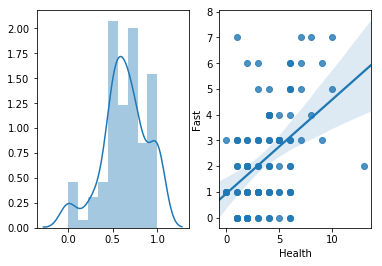

In [20]:
grouped = grouped[grouped['all']!=0]
plt.subplot(1,2,1)
sns.distplot(grouped['Health']/grouped['all'])
plt.subplot(1,2,2)
sns.regplot(grouped['Health'],grouped['Fast'])

The graph on the left shows the frequency of each ratio of affordable health food to all affordable options. 0.5 is the most common, meaning for most neighbourhoods about half the food stores are healthy. The graph on the right shows that in most cases more stores will usually mean both more healthy and convenient stores, but there are many exceptions.

In [21]:
kclusters = 3
grouped_clustering = grouped.drop('Neighborhood', 1).drop('all',1).drop('Health',1).drop('Fast',1)
grouped_clustering2 = grouped[['Health','Fast']]

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)
kmeans2 = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering2)

I tried 2 different k cluster algorithms. For both I used 3 algorithms to try and represent little food access, good food access, and great food access. In one algorithm the clusters were determined solely by the frequency of each business. The other was determined using the number of healthy and fastfood stores.

In [22]:
grouped.insert(0, 'Cluster Labels', kmeans.labels_)
grouped.insert(0, 'Cluster Labels 2', kmeans2.labels_)

merged = neighborhoods
merged = merged.join(grouped.set_index('Neighborhood'), on='Neighborhood')

merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels 2,Cluster Labels,Butcher,Convenience Store,Farmers Market,Fast Food Restaurant,Fish Market,Food Court,Food Truck,Grocery Store,Organic Grocery,Supermarket,Health,Fast,all
0,Bronx,Wakefield,40.894705,-73.847201,2.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,8.0
1,Bronx,Co-op City,40.874294,-73.829939,2.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,4.0,8.0
2,Bronx,Eastchester,40.887556,-73.827806,2.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,4.0,8.0
3,Bronx,Fieldston,40.895437,-73.905643,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,Bronx,Riverdale,40.890834,-73.912585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
merged.dropna(inplace=True)
merged['Cluster Labels 2'] = merged['Cluster Labels 2'].astype(int)
merged['Cluster Labels'] = merged['Cluster Labels'].astype(int)
merged.head(10)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels 2,Cluster Labels,Butcher,Convenience Store,Farmers Market,Fast Food Restaurant,Fish Market,Food Court,Food Truck,Grocery Store,Organic Grocery,Supermarket,Health,Fast,all
0,Bronx,Wakefield,40.894705,-73.847201,2,0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,8.0
1,Bronx,Co-op City,40.874294,-73.829939,2,0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,4.0,8.0
2,Bronx,Eastchester,40.887556,-73.827806,2,0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,4.0,8.0
3,Bronx,Fieldston,40.895437,-73.905643,0,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,Bronx,Kingsbridge,40.881687,-73.902818,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0
7,Bronx,Woodlawn,40.898273,-73.867315,0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,3.0
8,Bronx,Norwood,40.877224,-73.879391,2,0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,3.0,7.0
9,Bronx,Williamsbridge,40.881039,-73.857446,0,2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,4.0
10,Bronx,Baychester,40.866858,-73.835798,2,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,2.0,6.0
11,Bronx,Pelham Parkway,40.857413,-73.854756,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0


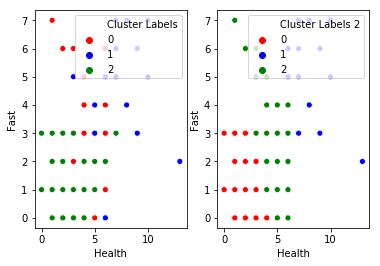

In [30]:
palette = ['red','blue', 'green']
plt.subplot(1,2,1)
sns.scatterplot(x='Health', y='Fast',hue='Cluster Labels',data=merged,palette=palette)
plt.subplot(1,2,2)
sns.scatterplot(x='Health', y='Fast',hue='Cluster Labels 2',data=merged,palette=palette)

Both algorithms had a similar output. Though cluster 2 unsurprisingly fits the 'Health vs Fast' graph better.

In [31]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

import matplotlib.cm as cm
import matplotlib.colors as colors

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels 2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The red dots on the map have poor food access. The green dots have the best access. The best place to place a grocery store would be where there are as few green dots and as many red dots as possible. Neighbourhoods on or near the coast tend to have worse food access, likely because there fewer businesses within a mile radius. 